<a href="https://colab.research.google.com/github/trongtn2110/CS114.L21/blob/master/Colab/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CUNG CẤP CÁC THƯ VIỆN CẦN THIẾT**

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
import string , re
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**LẤY DỮ LIỆU ĐÃ THU THẬP**

In [38]:
df = pd.read_json('https://raw.githubusercontent.com/trongtn2110/CS114.L21/master/Colab/merged_new_42.json',orient='records')
df.head()

,headline,is_sarcastic
0,Ed Anger Archives,1
1,NewsMax TV Host Thinks Jussie Smollett Got Off...,0
2,Punk Spirit Asks Ouija Board Players If It Can...,1
3,Here Are Some Weird Top-Selling Amazon Products,0
4,Big Oil Says You’re Safe From These Toxic Clou...,0


#**KHÁM PHÁ DỮ LIỆU**

In [39]:
df.isna().sum() # Kiểm tra NaN

headline        0
is_sarcastic    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


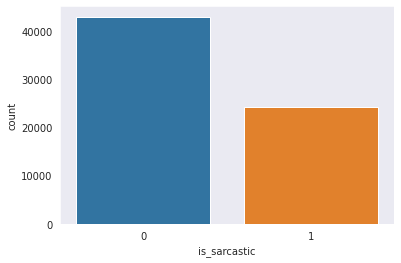

In [40]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

#**XỬ LÝ DATA**

##**LOẠI BỎ CÁC STOPWORDS**


> Stopwords là những từ tiếng Anh không bổ sung nhiều ý nghĩa cho một câu. Chúng có thể được bỏ qua một cách an toàn mà không làm mất đi ý nghĩa của câu. Ví dụ, những từ như, anh ấy, có, vv Những từ như vậy đã được ghi lại điều này trong ngữ liệu có tên là ngữ liệu.


In [41]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

##**XÓA CÁC KÍ TỰ KHÔNG THỂ XỬ LÝ**

In [43]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Xóa các dấu ngoặc
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Xóa URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Xóa các stopwords
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
def denoise_text(text):
    text = text.lower()
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
df['headline']=df['headline'].apply(denoise_text)

##**CHUYỂN ĐỔI DATA CHO PHÙ HỢP VỚI MODEL WORD2VEC**

In [44]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['ed', 'anger', 'archives'],
 ['newsmax',
  'tv',
  'host',
  'thinks',
  'jussie',
  'smollett',
  'got',
  'easier',
  'roseanne',
  'barr'],
 ['punk', 'spirit', 'asks', 'ouija', 'board', 'players', 'borrow', 'amp'],
 ['weird', 'top-selling', 'amazon', 'products'],
 ['big', 'oil', 'says', 'you’re', 'safe', 'toxic', 'clouds.', 'you’re']]

In [45]:
import gensim
EMBEDDING_DIM = 200
#Tạo model w2v
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , min_count = 1)

##**MÃ HÓA DATA**

In [46]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [ ]:
# print(tokenizer.word_counts)
# print(tokenizer.document_count)
# print(tokenizer.word_index)
# print(tokenizer.word_docs)

In [47]:
#Cộng 1 vì dành cho các từ không biết, vector này sẽ toàn 0
vocab_size = len(tokenizer.word_index) + 1

In [48]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [49]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


#**TRAIN MODEL**

In [50]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           13951600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 14,344,241
Trainable params: 14,344,241
Non-trainable params: 0
_________________________________________________________________


In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [33]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
368/368 [==============================] - 235s 637ms/step - loss: 0.0038 - acc: 0.9987 - val_loss: 0.2846 - val_acc: 0.9506
Epoch 2/3
368/368 [==============================] - 234s 637ms/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.3565 - val_acc: 0.9486
Epoch 3/3
368/368 [==============================] - 234s 637ms/step - loss: 0.0027 - acc: 0.9990 - val_loss: 0.3448 - val_acc: 0.9472


In [34]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

1470/1470 [==============================] - 39s 27ms/step - loss: 6.2792e-04 - acc: 0.9998
Accuracy of the model on Training Data is -  99.97660517692566
630/630 [==============================] - 17s 27ms/step - loss: 0.3448 - acc: 0.9472
Accuracy of the model on Testing Data is -  94.71569061279297


#**NHẬN XÉT**
- Thấy kết quả accuracy score trên Testing Data là 94.7 là khá cao so với accuracy score trên Training Data là 99.9